Confirmed by Omar

The FairJob dataset, released by Criteo, is designed to help researchers explore fairness in AI systems, specifically in the context of online advertising. This dataset focuses on understanding click prediction models and evaluating potential biases in predictions between different gender groups. Here's a breakdown of the key elements:

Dataset Overview:
Size: 1,072,226 rows and 55 columns.

Purpose: To train click prediction models and assess gender bias in click predictions.

Context: Collected from a job targeting campaign run for 5 months by Criteo, it includes anonymized user and product data, as well as features relevant to online advertising.

In [ ]:
!pip install transformers datasets

In [3]:
# Check GPU availability
!nvidia-smi

Thu Apr 17 14:20:34 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   51C    P8             11W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [68]:
import cudf
from datasets import load_dataset
import cudf
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from imblearn.over_sampling import SMOTE
import pandas as pd
from cuml.svm import SVC
from cuml.neighbors import KNeighborsClassifier
import xgboost as xgb

import joblib


In [5]:

ds = load_dataset("criteo/FairJob")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [6]:
ds.shape

{'train': (1072226, 56)}

In [7]:
df = cudf.DataFrame.from_pandas(ds['train'].to_pandas())



In [8]:
print(ds.keys())

dict_keys(['train'])


In [9]:
df.head(10)

,click,protected_attribute,senior,displayrandom,rank,user_id,impression_id,product_id,cat0,cat1,...,num41,num42,num43,num44,num45,num46,num47,num48,num49,num50
0,0,0,1,1,1,31020,175316,45953,6,6,...,-0.333033,-0.542801,0.074884,-0.751637,-0.299223,-0.647541,-0.252768,-0.577173,-0.264359,-0.737299
1,0,0,1,0,3,515,129699,10569,8,8,...,-0.333033,-0.542801,-0.258659,0.503731,-0.523668,1.088225,0.935563,-0.577173,0.507790,0.610287
2,0,1,1,0,1,12859,134573,51550,6,6,...,-0.333033,-0.542801,-0.236209,-0.111510,0.084159,0.422154,-0.160055,-0.577173,-0.264359,-0.063506
3,0,1,1,0,1,18781,84169,17843,3,3,...,-0.333033,-0.542801,-0.393358,-0.987701,-0.523668,-0.778977,-0.345480,-0.577173,4.368537,-0.996450
4,0,0,1,0,9,19283,76506,11354,8,8,...,-0.333033,-0.542801,1.553377,-0.636441,-0.523668,-0.541088,-0.345480,-0.577173,-0.264359,-0.581808
5,0,0,1,1,4,10388,112957,55540,8,8,...,-0.333033,-0.542801,-0.252244,-0.534058,-0.267055,-0.240152,-0.252768,-0.153896,-0.264359,-0.322657
6,1,0,0,1,2,17098,58005,52106,3,3,...,-0.333033,-0.542801,-0.393358,-0.937521,-0.314541,0.505693,-0.345480,-0.577173,-0.264359,-0.892789
7,0,1,0,0,6,11721,134329,19484,6,6,...,-0.333033,-0.542801,-0.393358,1.471117,0.753036,0.053634,-0.345480,-0.577173,-0.264359,1.595062
8,0,1,1,0,4,20033,100155,52556,8,8,...,-0.333033,-0.542801,-0.393358,-0.887341,0.259764,1.039174,-0.345480,0.257664,-0.264359,-0.840959
9,0,1,0,0,17,18002,113770,5667,8,8,...,0.582689,0.646535,-0.277901,0.955322,-0.500162,-0.121026,1.786906,-0.577173,-0.264359,1.024929


In [10]:
df.info()

<class 'cudf.core.dataframe.DataFrame'>
RangeIndex: 1072226 entries, 0 to 1072225
Data columns (total 56 columns):
 #   Column               Non-Null Count    Dtype
---  ------               --------------    -----
 0   click                1072226 non-null  int64
 1   protected_attribute  1072226 non-null  int64
 2   senior               1072226 non-null  int64
 3   displayrandom        1072226 non-null  int64
 4   rank                 1072226 non-null  int64
 5   user_id              1072226 non-null  int64
 6   impression_id        1072226 non-null  int64
 7   product_id           1072226 non-null  int64
 8   cat0                 1072226 non-null  int64
 9   cat1                 1072226 non-null  int64
 10  cat2                 1072226 non-null  int64
 11  cat3                 1072226 non-null  int64
 12  cat4                 1072226 non-null  int64
 13  cat5                 1072226 non-null  int64
 14  cat6                 1072226 non-null  int64
 15  cat7                 1072226 n

In [11]:
print("Shape of Data:", df.shape)

Shape of Data: (1072226, 56)


In [12]:

print(" Missing Values:\n", df.isnull().sum())


 Missing Values:
 click                  0
protected_attribute    0
senior                 0
displayrandom          0
rank                   0
user_id                0
impression_id          0
product_id             0
cat0                   0
cat1                   0
cat2                   0
cat3                   0
cat4                   0
cat5                   0
cat6                   0
cat7                   0
cat8                   0
cat9                   0
cat10                  0
cat11                  0
cat12                  0
num16                  0
num17                  0
num18                  0
num19                  0
num20                  0
num21                  0
num22                  0
num23                  0
num24                  0
num25                  0
num26                  0
num27                  0
num28                  0
num29                  0
num30                  0
num31                  0
num32                  0
num33                  0
num34  

In [13]:
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns
desc_stats = df[numerical_cols].describe()
desc_stats

,click,protected_attribute,senior,displayrandom,rank,user_id,impression_id,product_id,cat0,cat1,...,num41,num42,num43,num44,num45,num46,num47,num48,num49,num50
count,1.072226e+06,1072226.0,1.072226e+06,1.072226e+06,1.072226e+06,1.072226e+06,1.072226e+06,1.072226e+06,1.072226e+06,1.072226e+06,...,1.072226e+06,1.072226e+06,1.072226e+06,1.072226e+06,1.072226e+06,1.072226e+06,1.072226e+06,1.072226e+06,1.072226e+06,1.072226e+06
mean,6.985000e-03,0.5,6.655860e-01,9.873800e-02,6.172810e+00,1.599122e+04,1.319778e+05,3.064587e+04,6.375651e+00,6.715985e+00,...,-2.016000e-03,3.000000e-05,-1.030200e-02,-2.034800e-02,5.085000e-03,1.354000e-03,1.538000e-03,-1.192200e-02,-1.447000e-03,-2.136100e-02
std,8.328100e-02,0.5,4.717850e-01,2.983090e-01,4.752105e+00,9.186927e+03,6.477362e+04,1.772469e+04,2.168938e+00,1.772106e+00,...,9.815470e-01,1.002444e+00,9.965940e-01,9.896210e-01,1.029254e+00,1.018628e+00,1.010206e+00,9.816350e-01,9.991480e-01,9.880160e-01
min,0.000000e+00,0.0,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,-3.330330e-01,-5.428010e-01,-3.933580e-01,-9.877010e-01,-5.236680e-01,-7.789770e-01,-3.454800e-01,-5.771730e-01,-2.643590e-01,-9.964500e-01
25%,0.000000e+00,0.0,0.000000e+00,0.000000e+00,2.000000e+00,8.013000e+03,7.858000e+04,1.484900e+04,6.000000e+00,6.000000e+00,...,-3.330330e-01,-5.428010e-01,-3.933580e-01,-8.371610e-01,-4.946520e-01,-6.201580e-01,-3.454800e-01,-5.771730e-01,-2.643590e-01,-8.409590e-01
50%,0.000000e+00,0.5,1.000000e+00,0.000000e+00,5.000000e+00,1.610000e+04,1.301310e+05,3.073700e+04,7.000000e+00,8.000000e+00,...,-3.330330e-01,-5.428010e-01,-3.548730e-01,-3.830230e-01,-3.495720e-01,-3.031990e-01,-3.454800e-01,-5.771730e-01,-2.643590e-01,-3.744870e-01
75%,0.000000e+00,1.0,1.000000e+00,0.000000e+00,9.000000e+00,2.407575e+04,1.887210e+05,4.574000e+04,8.000000e+00,8.000000e+00,...,-5.043500e-02,9.253470e-01,-4.698700e-02,5.678780e-01,8.566800e-02,2.392570e-01,-6.734300e-02,2.576640e-01,-2.643590e-01,5.584570e-01
max,1.000000e+00,1.0,1.000000e+00,1.000000e+00,4.000000e+01,3.187900e+04,2.463600e+05,6.215300e+04,8.000000e+00,8.000000e+00,...,4.036110e+01,1.232409e+01,1.978277e+01,1.429750e+01,3.273832e+01,2.052098e+01,2.233434e+01,1.857488e+01,2.367227e+01,1.481177e+01


In [14]:
correlation_matrix= df.corr()

In [15]:
correlation_matrix_pd = correlation_matrix.to_pandas()


<ipython-input-16-333c3c66424a>:6: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


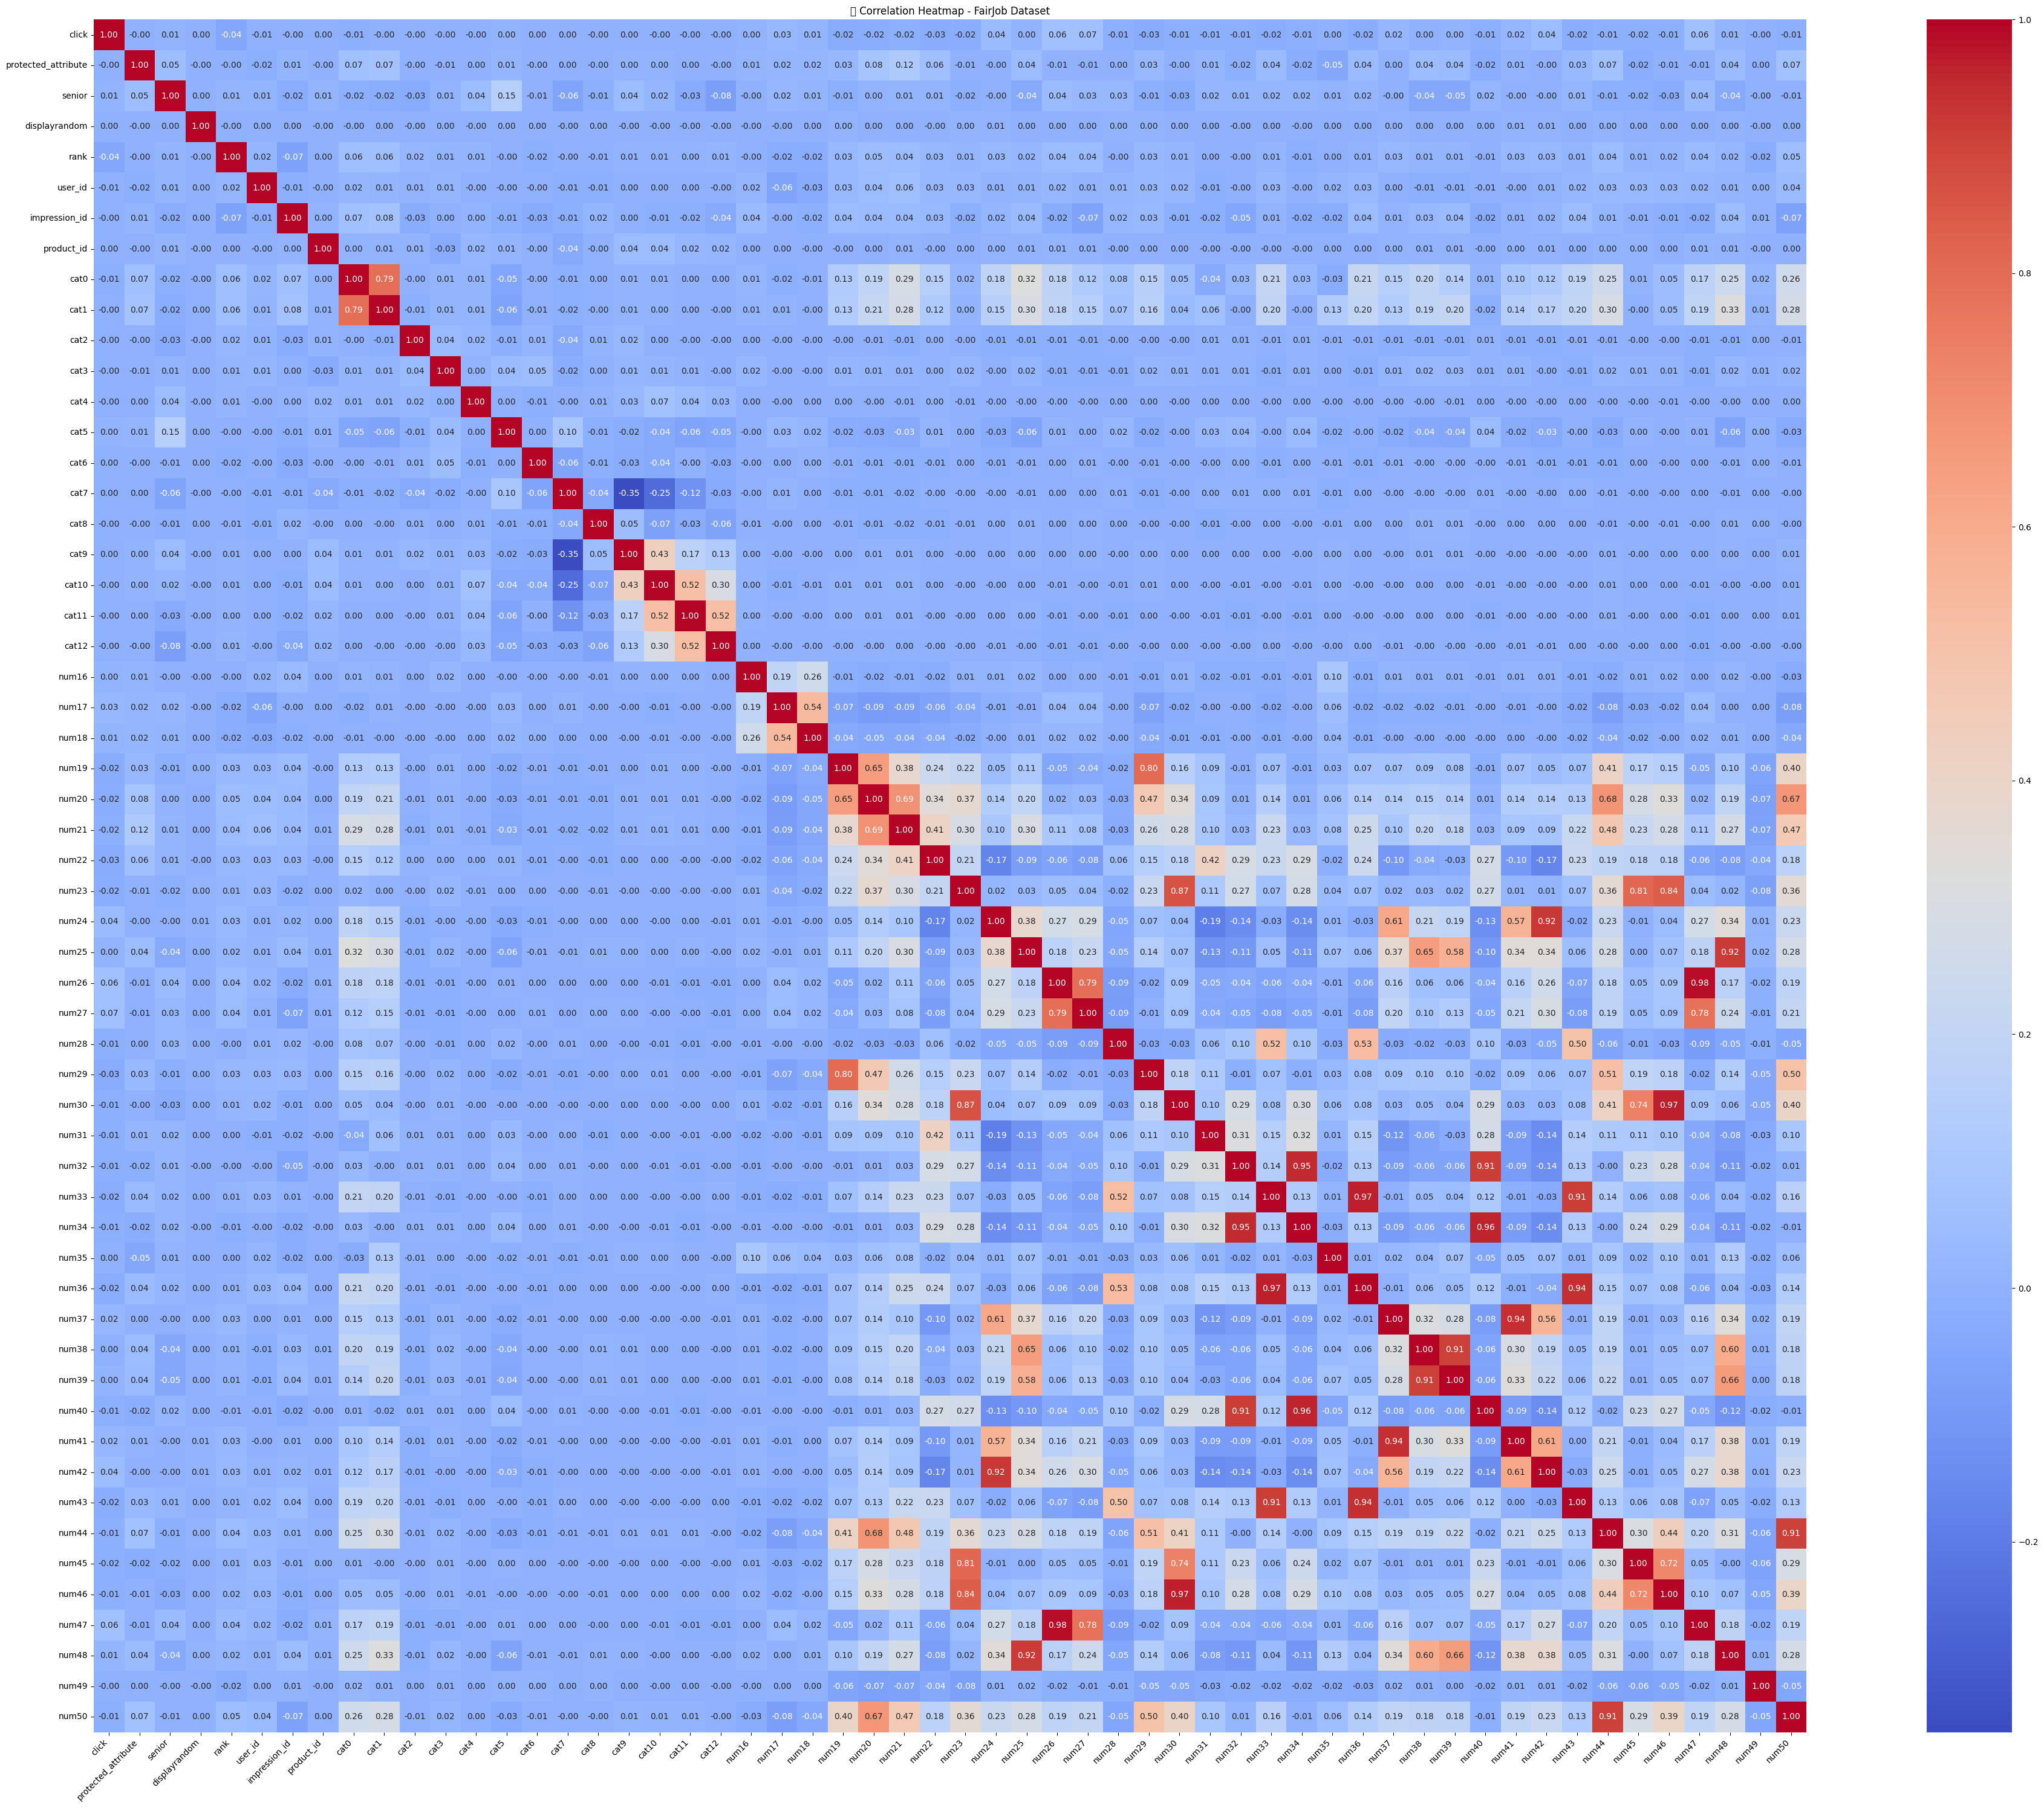

In [16]:
plt.figure(figsize=(40, 30))
sns.heatmap(correlation_matrix_pd, cmap='coolwarm', annot=True, fmt=".2f", square=True)
plt.title("📊 Correlation Heatmap - FairJob Dataset")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [17]:
df.head(1)

,click,protected_attribute,senior,displayrandom,rank,user_id,impression_id,product_id,cat0,cat1,...,num41,num42,num43,num44,num45,num46,num47,num48,num49,num50
0,0,0,1,1,1,31020,175316,45953,6,6,...,-0.333033,-0.542801,0.074884,-0.751637,-0.299223,-0.647541,-0.252768,-0.577173,-0.264359,-0.737299



✅ Click Distribution:
 click
0    1064737
1       7489
Name: count, dtype: int64


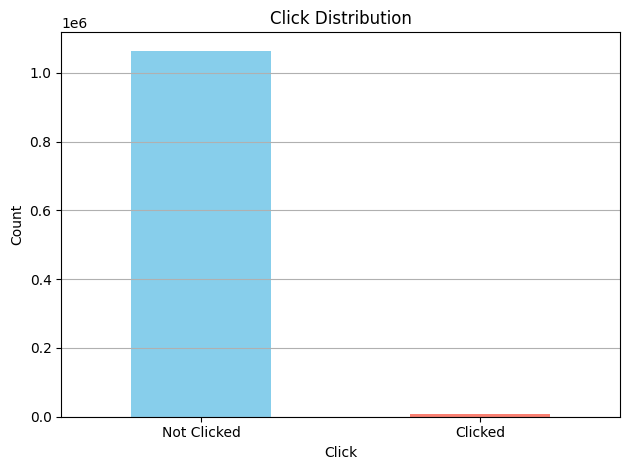

In [18]:
click_counts = df["click"].value_counts()
print("\n✅ Click Distribution:\n", click_counts)

# Plot Click Distribution
click_counts.to_pandas().plot(kind='bar', color=["skyblue", "salmon"])
plt.title("Click Distribution")
plt.xlabel("Click")
plt.ylabel("Count")
plt.xticks(ticks=[0, 1], labels=["Not Clicked", "Clicked"], rotation=0)
plt.grid(axis="y")
plt.tight_layout()
plt.show()


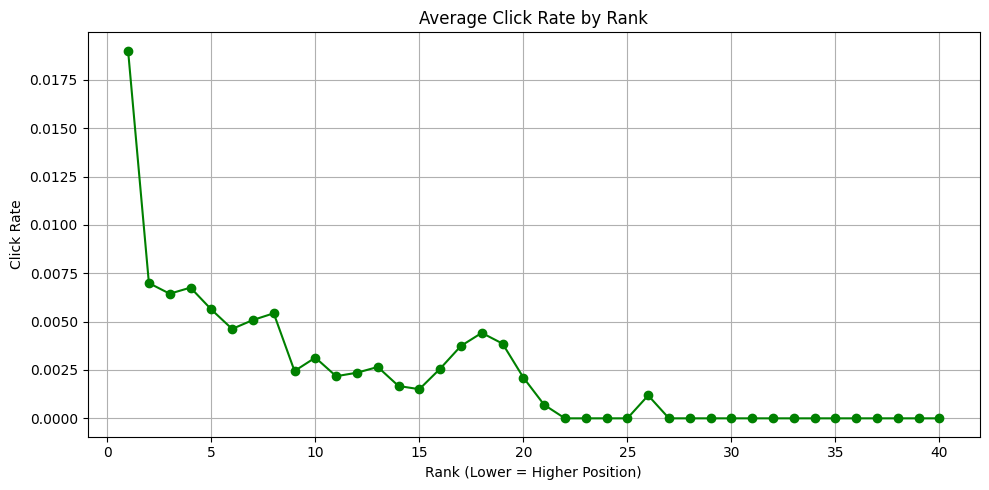

In [19]:
avg_click_by_rank = df.groupby("rank").mean()["click"].sort_index().to_pandas()

plt.figure(figsize=(10, 5))
avg_click_by_rank.plot(marker='o', color="green")
plt.title("Average Click Rate by Rank")
plt.xlabel("Rank (Lower = Higher Position)")
plt.ylabel("Click Rate")
plt.grid(True)
plt.tight_layout()
plt.show()

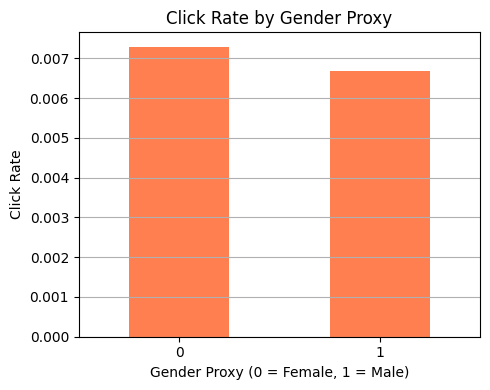

In [20]:
gender_click_rate = df.groupby("protected_attribute").mean()["click"].to_pandas()

plt.figure(figsize=(5, 4))
gender_click_rate.plot(kind="bar", color="coral")
plt.title("Click Rate by Gender Proxy")
plt.xlabel("Gender Proxy (0 = Female, 1 = Male)")
plt.ylabel("Click Rate")
plt.xticks(rotation=0)
plt.grid(axis="y")
plt.tight_layout()
plt.show()

In [21]:
from cuml.ensemble import RandomForestClassifier as cuRF
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score



In [22]:
target = 'click'
X = df.drop(target, axis=1)
y = df[target]

In [23]:
X_train, X_test, y_train, y_test = train_test_split(
   X, y, test_size=0.20, random_state=42)


/usr/local/lib/python3.11/dist-packages/cudf/core/dataframe.py:7737: FutureWarning: Using `__dataframe__` is deprecated
  warnings.warn("Using `__dataframe__` is deprecated", FutureWarning)


In [24]:
cuRF = cuRF()


In [25]:
cuRF.fit(X_train, y_train)

RandomForestClassifier()

In [26]:
y_pred = cuRF.predict(X_test)

In [27]:
y_pred

753729    0
122436    0
523634    0
229605    0
614626    0
         ..
546291    0
348839    0
639903    0
850062    0
281774    0
Length: 214446, dtype: int64

In [28]:
y_test

753729    0
122436    0
523634    0
229605    0
614626    0
         ..
546291    0
348839    0
639903    0
850062    0
281774    0
Name: click, Length: 214446, dtype: int64

In [29]:
accuracy_cuRF = accuracy_score(y_test.to_numpy() ,y_pred.to_numpy())

In [30]:
y_pred = cuRF.predict(X_test)
accuracy_cuRF = accuracy_score(y_test.to_numpy() ,y_pred.to_numpy())
precision = precision_score(y_test.to_numpy() ,y_pred.to_numpy())
recall = recall_score(y_test.to_numpy() ,y_pred.to_numpy())
print(f"🎯 Precision: {accuracy_cuRF:.4f}")

print(f"🎯 Precision: {precision:.4f}")
print(f"🎯 Recall:    {recall:.4f}")


🎯 Precision: 0.9933
🎯 Precision: 0.6000
🎯 Recall:    0.0021


In [31]:
# the proplem of imbalanced datasets

click_counts = df["click"].value_counts()

click_counts

click
0    1064737
1       7489
Name: count, dtype: int64

In [32]:
df["click"].shape [0]

1072226

In [33]:
df["click"].value_counts() [0]

np.int64(1064737)

In [34]:
df["click"].shape [0] / df["click"].value_counts() [0]

np.float64(1.0070336618338613)

In [35]:

sm = SMOTE()


In [36]:
X_resampled, y_resampled = sm.fit_resample(X_train.to_numpy(), y_train.to_numpy())


In [37]:
print("Original:", y_train.value_counts())
print("After SMOTE:", pd.Series(y_resampled).value_counts())

Original: click
0    851730
1      6050
Name: count, dtype: int64
After SMOTE: 0    851730
1    851730
Name: count, dtype: int64


In [38]:
X_resampled, y_resampled = sm.fit_resample(X_train.to_pandas(), y_train.to_pandas())


In [39]:
X_resampled = cudf.DataFrame.from_pandas(X_resampled)


In [40]:
y_resampled = cudf.DataFrame.from_pandas(y_resampled.to_frame())


In [41]:
print("Original:", y_train.value_counts())
print("After SMOTE:", y_resampled.value_counts())

Original: click
0    851730
1      6050
Name: count, dtype: int64
After SMOTE: click
1        851730
0        851730
Name: count, dtype: int64


In [42]:
y_resampled_series = y_resampled.iloc[:, 0]  # or use .squeeze() if you prefer

# Fit the model
cuRF.fit(X_resampled, y_resampled_series)

RandomForestClassifier()

In [43]:
y_resampled_series

0          0
1          0
2          0
3          0
4          0
          ..
1703455    1
1703456    1
1703457    1
1703458    1
1703459    1
Name: click, Length: 1703460, dtype: int64

In [44]:
y_pred = cuRF.predict(X_test)
accuracy_cuRF = accuracy_score(y_test.to_numpy() ,y_pred.to_numpy())
precision = precision_score(y_test.to_numpy() ,y_pred.to_numpy())
recall = recall_score(y_test.to_numpy() ,y_pred.to_numpy())
print(f"🎯 accuracy: {accuracy_cuRF:.4f}")

print(f"🎯 Precision: {precision:.4f}")
print(f"🎯 Recall:    {recall:.4f}")


🎯 accuracy: 0.9791
🎯 Precision: 0.0485
🎯 Recall:    0.1140


In [45]:
from sklearn.metrics import confusion_matrix

y_pred = cuRF.predict(X_test)
print(confusion_matrix(y_test.to_numpy() ,y_pred.to_numpy()))


[[209791   3216]
 [  1275    164]]


In [46]:
from cuml.ensemble import RandomForestClassifier

cuRF = RandomForestClassifier(n_estimators=400, max_depth=25, random_state=42)
cuRF.fit(X_resampled, y_resampled_series)


/usr/local/lib/python3.11/dist-packages/cuml/internals/api_decorators.py:368: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams=1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  return init_func(self, *args, **kwargs)


RandomForestClassifier()

In [47]:
y_pred = cuRF.predict(X_test)
accuracy_cuRF = accuracy_score(y_test.to_numpy() ,y_pred.to_numpy())
precision = precision_score(y_test.to_numpy() ,y_pred.to_numpy())
recall = recall_score(y_test.to_numpy() ,y_pred.to_numpy())
print(f" accuracy: {accuracy_cuRF:.4f}")

print(f" Precision: {precision:.4f}")
print(f" Recall:    {recall:.4f}")


 accuracy: 0.9915
 Precision: 0.0939
 Recall:    0.0313


In [48]:
print(confusion_matrix(y_test.to_numpy() ,y_pred.to_numpy()))


[[212573    434]
 [  1394     45]]


In [54]:
from cuml.linear_model import LogisticRegression

clf_Log = LogisticRegression()
clf_Log.fit(X_resampled, y_resampled_series)
y_pred = clf_Log.predict(X_test)
precision = precision_score(y_test.to_numpy() ,y_pred.to_numpy())
recall = recall_score(y_test.to_numpy() ,y_pred.to_numpy())
print(f"accuracy: {accuracy_cuRF:.4f}")

print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")

accuracy: 0.9915
Precision: 0.0070
Recall:    0.5066


In [50]:
print('hh')

hh


In [64]:
model_xgb = xgb.XGBRegressor(
    objective='binary:logistic',
    eval_metric = 'logloss',
    tree_method='gpu_hist',
    predictor='gpu_predictor',

    random_state=42
)

model_xgb.fit(X_resampled, y_resampled_series)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:30:59] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:30:59] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='logloss',
             feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, objective='binary:logistic', ...)

In [67]:
from cuml.linear_model import LogisticRegression



y_pred_prob = model_xgb.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)
precision = precision_score(y_test.to_numpy() ,y_pred)
recall = recall_score(y_test.to_numpy() ,y_pred)
print(f"accuracy: {accuracy_cuRF:.4f}")

print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")

accuracy: 0.9915
Precision: 0.1188
Recall:    0.0215


In [59]:
y_test.to_numpy()

array([0, 0, 0, ..., 0, 0, 0])

In [66]:
y_pred

array([0, 0, 0, ..., 0, 0, 0])

In [69]:
joblib.dump(model_xgb, 'model_xgb.joblib')


['model_xgb.joblib']

In [70]:
# Select first 100 samples
X_sample = X_test.head(100)
y_sample = y_test.head(100)

# Save to CSV
X_sample.to_csv("X_test_sample.csv", index=False)
y_sample.to_frame(name='target').to_csv("y_test_sample.csv", index=False)